In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import optim

import math
import numpy as np
import pandas as pd
from arff2pandas import a2p
import io
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
art_daily_small=pd.read_csv('Input/art_daily_small_noise.csv', parse_dates=True, index_col='timestamp')
art_daily_jump=pd.read_csv('Input/art_daily_jumpsup.csv', parse_dates=True, index_col='timestamp')

<AxesSubplot:xlabel='timestamp'>

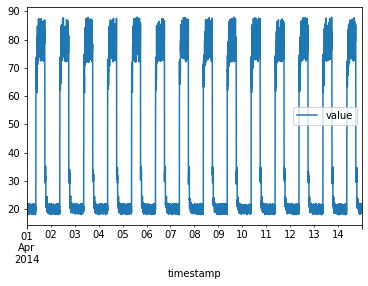

In [7]:
art_daily_small.plot()

In [9]:
training_mean = art_daily_small.mean()
training_std = art_daily_small.std()
df_training_value = (art_daily_small - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [10]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


# CNN Model

In [166]:
class CNNAutoencoder(nn.Module):
    def __init__(self,seq_len=TIME_STEPS,n_features=1):
        super(CNNAutoencoder,self).__init__()
        
        self.seq_len=seq_len
        self.n_features=n_features
        
        self.conv1=nn.Sequential(nn.Conv1d(1,32, kernel_size=7,stride=2,padding=3),nn.ReLU(),nn.Dropout(0.2))
        self.conv2=nn.Sequential(nn.Conv1d(32,16,kernel_size=7,stride=2,padding=3),nn.ReLU())
        
        self.conv1T=nn.Sequential(nn.ConvTranspose1d(16,16,kernel_size=7,padding=3,stride=2,output_padding=1),nn.ReLU(),nn.Dropout(0.2))
        self.conv2T=nn.Sequential(nn.ConvTranspose1d(16,32,kernel_size=7,stride=2,padding=3,output_padding=1),nn.ReLU())
        self.conv3T=nn.ConvTranspose1d(32,1,kernel_size=7,padding=3,stride=1,output_padding=0)
        
        self.encoder=nn.Sequential(self.conv1,self.conv2)
        self.decoder=nn.Sequential(self.conv1T,self.conv2T,self.conv3T)
        
    def forward(self,x):
        # x.size: batch, seq_len, n_features
        x=x.transpose(1,2)
        #x.size= batch, n_features, seq_len
        x=self.encoder(x)
        x=self.decoder(x)
        
        return x.transpose(1,2)
    
    @property
    def get_n_params(self):
        pp=0
        for p in list(self.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp

In [156]:
def Lout(Lin,padding,stride,kernel,dilation=1):
    
    return (Lin+2*padding-dilation*(kernel-1) -1)//stride +1

def LoutT(Lin,padding,stride,kernel,out_padding,dilation=1):
    
    return (Lin-1)*stride-2*padding+dilation*(kernel-1)+out_padding+1

In [16]:
class MYDataset(Dataset):
    def __init__(self,X):
        self.x=X
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return torch.FloatTensor(self.x[index])

In [17]:
train_ds=MYDataset(x_train)

In [20]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=12, shuffle=True, num_workers=6)

In [30]:
for a in train_dl:
    break

# Training

In [171]:
def train_fct(model, train_loader, epochs, criterion, optimizer, device):
    L=len(train_loader)
    model.train()
    for epoch in range(1, epochs + 1):
         # Make sure that the model is in training mode.

        total_loss = 0
        hidden = None
        for batch in tqdm(train_loader):
            # get data
                       
            batch= batch.to(device)
            optimizer.zero_grad()

            # get predictions from model
            pred = model(batch)
            
            # perform backprop
            loss = criterion( pred,batch)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data.item()
        
        print("Epoch: {}, Loss: {}".format(epoch, total_loss /L))
        
def val_score(model,test_dl,criterion):
    total_loss = 0
    L=len(test_dl)
    model.eval()
    for batch in tqdm(test_dl):
        # get data
        
        batch= batch.to(device)

        # get predictions from model
        pred = model(batch)
        loss=criterion(pred,batch)
        total_loss += loss.data.item()
    
    return (total_loss/L)

In [164]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device {}.".format(device))

Using device cuda.


In [167]:
model=CNNAutoencoder().to(device)

In [168]:
model.get_n_params

9505

In [169]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss(reduction='mean')

In [173]:
train_fct(model,train_dl,3,criterion,optimizer,device)

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.005730390114287218


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.005210445317537926


100%|██████████| 313/313 [00:01<00:00, 187.16it/s]

Epoch: 3, Loss: 0.004851287883965257


In [183]:
pred=model(train_ds[10].unsqueeze(0).to(device))

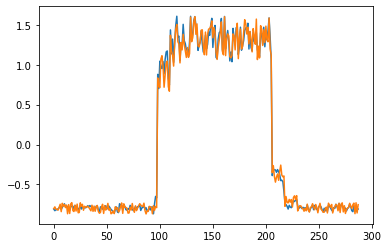

In [184]:
plt.plot(pred.cpu().detach().numpy()[0,:,0])
plt.plot(x_train[10])